In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import george
from george.modeling import Model
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole_map, dipole

In [3]:
sys.path.insert(0, '/home/aew492/CFE_gradients/funcs')
from convert_xyz_data import xyz_to_thetaphi, xyz_to_radec

#### functions

In [18]:
def plot_map(map, projection_type='mollweide', coord=['E','G'],
             graticule=True, graticule_labels=True, **kwargs):
    projview(map, projection_type=projection_type, coord=coord,
             graticule=graticule, graticule_labels=graticule_labels, **kwargs)

In [5]:
def flatten_map(sf_map):
    newarr = np.array([row[0] for row in sf_map])
    return np.reshape(newarr, (newarr.size,))

#### parameters

In [6]:
mapdir = '/scratch/aew492/quasars/maps'
NSIDE = 64
G = 20.5

### selection function without dipole

In [7]:
sf_nodip_tab = Table.read(os.path.join(mapdir, f'selection_function_NSIDE{NSIDE}_G{G}.fits'), format='fits')
selfunc_nodip = flatten_map(sf_nodip_tab)

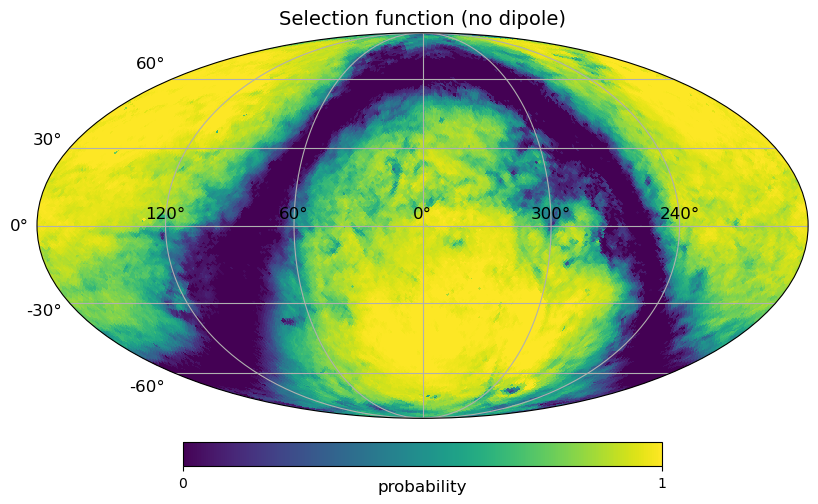

In [8]:
plot_map(selfunc_nodip, title='Selection function (no dipole)', unit='probability')

### selection function with dipole

In [9]:
nfit = 10000
sf_dip_tab = Table.read(os.path.join(mapdir, f'selection_function_NSIDE{NSIDE}_G{G}_dipole_{nfit}pix.fits'), format='fits')
selfunc_dip = flatten_map(sf_dip_tab)

In [114]:
np.where(selfunc_dip==0)[0].shape

(41283,)

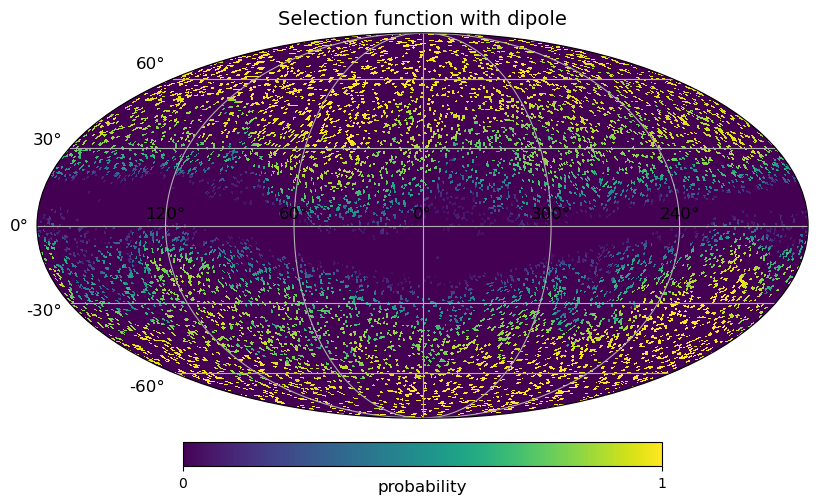

In [100]:
plot_map(selfunc_dip, title='Selection function with dipole', unit='probability', coord=['E','G'])

In [109]:
# residuals
fit_idx = np.where(selfunc_dip > 0)
res = selfunc_dip[fit_idx] - selfunc_nodip[fit_idx]
len(fit_idx[0])

7869

Text(0.5, 1.0, 'Selection function (dipole - no dipole) (7869 pixels)')

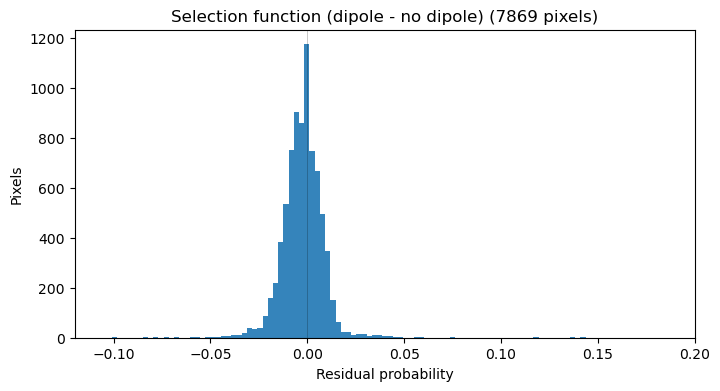

In [113]:
fig, ax = plt.subplots(figsize=(8,4))
_, _, _ = ax.hist(res, bins=130, alpha=0.9)
ax.axvline(0, color='k', lw=0.5, alpha=0.3)
ax.set_xlim((-.12,.2))
ax.set_xlabel('Residual probability')
ax.set_ylabel('Pixels')
ax.set_title(f'Selection function (dipole - no dipole) ({len(fit_idx[0])} pixels)')

In [27]:
# check dipole
dipoleamps = [2.15371222e+00, -2.90919857e-03, -6.73353246e-04, -8.34721914e-02]
dipmap = dipole_map(dipoleamps)

In [63]:
def plot_coord(theta, phi, frame='galactic', **kwargs):
    if type(theta)==u.quantity.Quantity:
        theta = theta.value
    if type(phi)==u.quantity.Quantity:
        phi = phi.value
    # check that input (theta,phi) have correct domain
    assert (phi >= 0) & (phi <= np.pi), "phi must be between 0 and pi"
    assert (theta >= -np.pi) & (theta <= np.pi), "theta must be between -pi and pi"
    # SkyCoord defines phi differently, from -pi to pi; fix this for the input
    phi -= np.pi/2
    coord = SkyCoord(theta, phi, unit=u.radian, frame='icrs')
    # plot (keeping in mind that theta and phi are switched for longitude and latitude)
    if frame=='galactic':
        b = coord.galactic.b.to('radian')
        l = coord.galactic.l.to('radian')
        print(f"b = {b.to('deg')}, l = {l.to('deg')}")
        newprojplot(b, l.wrap_at(np.pi*u.radian), **kwargs)
    elif frame=='icrs':
        dec = coord.dec.to('radian')
        ra = coord.ra.to('radian')
        print(f"ra = {ra.to('deg')}, dec = {dec.to('deg')}")
        newprojplot(dec+np.pi/2*u.radian, ra, **kwargs)
    else:
        assert False, "'frame' must be 'galactic' or 'icrs'"

theta =  0.0 deg phi =  90.0 deg
ra = 0.0 deg, dec = 0.0 deg


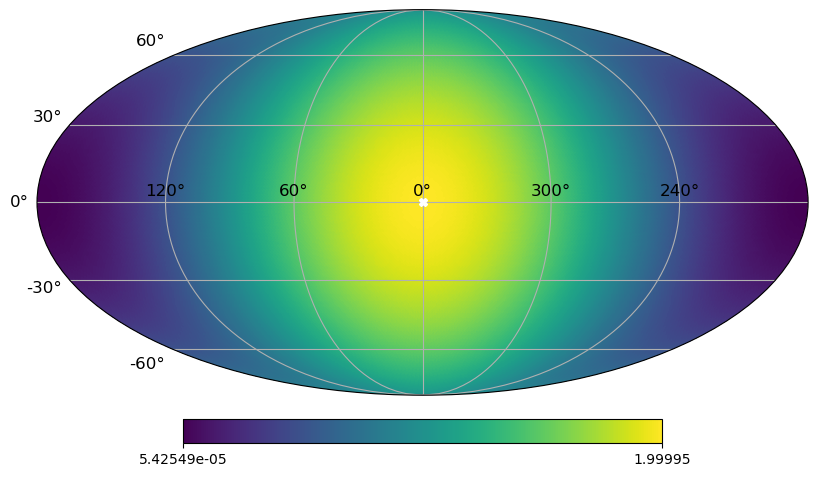

In [68]:
# sanity check on dipole amplitudes
testamps = [1,1,0,0]
theta, phi = xyz_to_thetaphi(testamps[1:])*u.radian
print("theta = ", theta.to('deg'), "phi = ", phi.to('deg'))
plot_map(dipole_map(testamps), coord=['E'], rot=(0,0,0))
plot_coord(theta, phi, frame='icrs', marker='X', color='white')

In [85]:
# CMB dipole
dip_cmb = SkyCoord(264.021, 48.253, unit=u.deg, frame='galactic')
dip_cmb.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (167.94190333, -6.94425998)>

In [93]:
# recovered dipole
theta, phi = xyz_to_thetaphi(dipoleamps[1:])*u.radian
print("theta = ", theta.to('deg'), "phi = ", phi.to('deg'))
ra, dec = theta, phi-np.pi/2*u.radian
dip_quaia = SkyCoord(ra, dec, unit=u.radian, frame='icrs')

theta =  -166.96799610342498 deg phi =  177.95119245259232 deg


In [94]:
dip_quaia

<SkyCoord (ICRS): (ra, dec) in deg
    (193.0320039, 87.95119245)>

ra = 193.03200389657502 deg, dec = 87.95119245259232 deg
-6d56m39.33591917s 167d56m30.8519762s


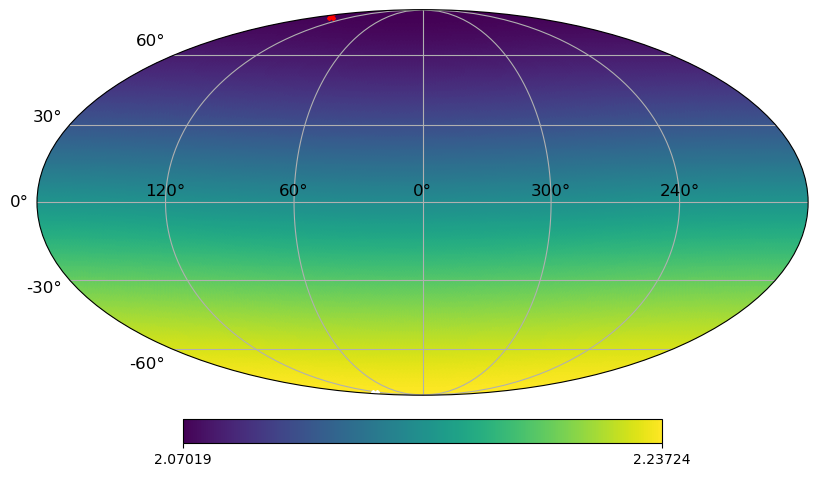

In [99]:
plot_map(dipole_map(dipoleamps), coord=['E'], rot=(0,0,0))
plot_coord(theta, phi, frame='icrs', marker='X', color='white')
print(dip_cmb.icrs.dec, dip_cmb.icrs.ra)
newprojplot(dip_cmb.icrs.dec.to('radian'), dip_cmb.icrs.ra.to('radian'), marker='X', color='r')

48d15m10.8s 264d01m15.6s
29d10m37.38178796s 122d55m29.49955117s


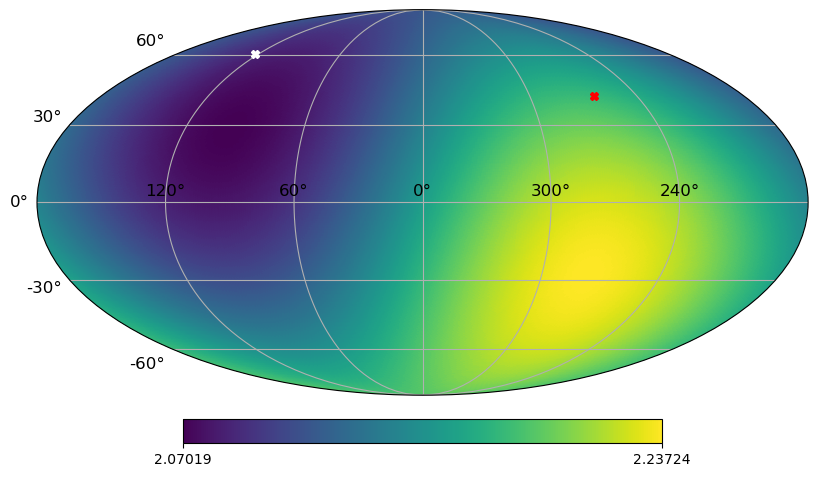

In [96]:
plot_map(dipole_map(dipoleamps), coord=['E','G'], rot=(0,0,0))
# plot_coord(theta, phi, frame='icrs', marker='X', color='white')
print(dip_cmb.b, dip_cmb.l)
print(dip_quaia.galactic.b, dip_quaia.galactic.l)
newprojplot(dip_cmb.b.to('radian'), dip_cmb.l.to('radian')-2*np.pi*u.radian, marker='X', color='r')
newprojplot(dip_quaia.galactic.b.to('radian'), dip_quaia.galactic.l.to('radian'), marker='X', color='white')